<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_merah_besar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f60244ab160>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_merah_besar.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


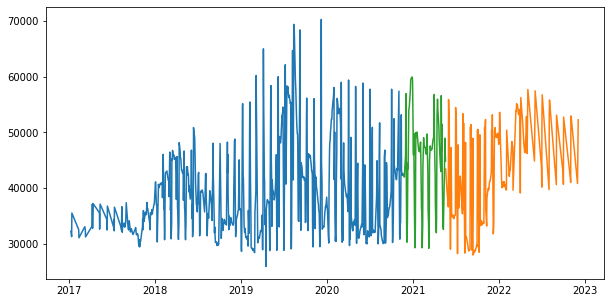

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabaimerahbesar_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [11]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [12]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [13]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 74ms/step - loss: 0.1253 - mae: 0.2971 - mape: 92.4699 - val_loss: 0.3007 - val_mae: 0.4965 - val_mape: 88.2517
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0926 - mae: 0.2370 - mape: 64.7582 - val_loss: 0.2479 - val_mae: 0.4406 - val_mape: 73.3204
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0722 - mae: 0.1959 - mape: 48.6718 - val_loss: 0.2107 - val_mae: 0.4016 - val_mape: 66.3232
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0589 - mae: 0.1744 - mape: 45.7333 - val_loss: 0.1822 - val_mae: 0.3725 - val_mape: 63.5158
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0504 - mae: 0.1649 - mape: 48.4218 - val_loss: 0.1616 - val_mae: 0.3512 - val_mape: 62.2567
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0449 - mae: 0.1595 - mape: 51.5299 - val_loss: 0.1470 - val_mae: 0.3356 - val_mape: 61.70

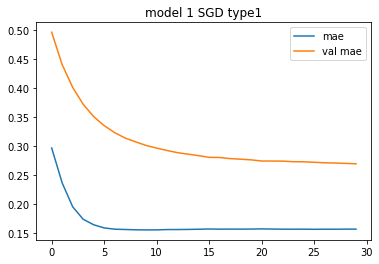

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
6694.0566 16.195866 7974.850970394368


,date,actual,prediction
0,2021-05-20,43400,40239.304688
1,2021-05-21,42450,40320.480469
2,2021-05-24,40150,40285.171875
3,2021-05-25,39600,40332.097656
4,2021-05-27,38600,40292.945312
...,...,...,...
229,2022-11-02,41000,41436.812500
230,2022-11-03,52950,41234.367188
231,2022-11-04,52850,41376.031250
232,2022-12-01,40800,41249.875000


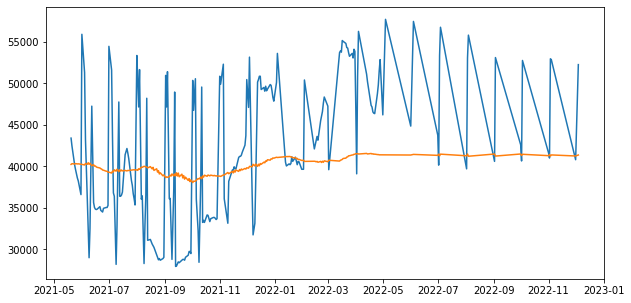

In [15]:
prediction = forecast_predict(model, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabaimerahbesar = pd.DataFrame()
data_new_cabaimerahbesar['date'] = y_test
data_new_cabaimerahbesar['actual'] = x_test
data_new_cabaimerahbesar['prediction'] = data_result
data_new_cabaimerahbesar.to_csv('cabaimerahbesar_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabaimerahbesar.date, data_new_cabaimerahbesar.actual)
plt.plot(data_new_cabaimerahbesar.date, data_new_cabaimerahbesar.prediction)
data_new_cabaimerahbesar

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0318 - mae: 0.1415 - mape: 397748.1562 - val_loss: 0.0871 - val_mae: 0.2640 - val_mape: 64.0810
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0316 - mae: 0.1410 - mape: 395855.9062 - val_loss: 0.0830 - val_mae: 0.2570 - val_mape: 64.4468
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0315 - mae: 0.1397 - mape: 389296.7188 - val_loss: 0.0813 - val_mae: 0.2539 - val_mape: 64.6245
Epoch 4/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0313 - mae: 0.1396 - mape: 432698.3750 - val_loss: 0.0818 - val_mae: 0.2547 - val_mape: 64.6459
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0309 - mae: 0.1387 - mape: 457507.6562 - val_loss: 0.0820 - val_mae: 0.2549 - val_mape: 64.6756
Epoch 6/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0307 - mae: 0.1379 - mape: 382611.3125 - val_loss: 0.0793 - val_

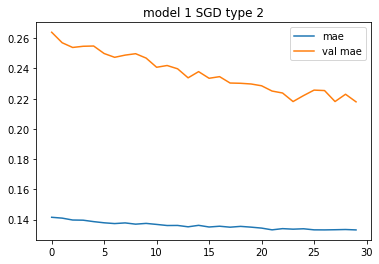

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6015.5986 14.778108 7075.767944188107


,date,actual,prediction
0,2021-05-20,43400,40239.304688
1,2021-05-21,42450,40320.480469
2,2021-05-24,40150,40285.171875
3,2021-05-25,39600,40332.097656
4,2021-05-27,38600,40292.945312
...,...,...,...
229,2022-11-02,41000,41436.812500
230,2022-11-03,52950,41234.367188
231,2022-11-04,52850,41376.031250
232,2022-12-01,40800,41249.875000


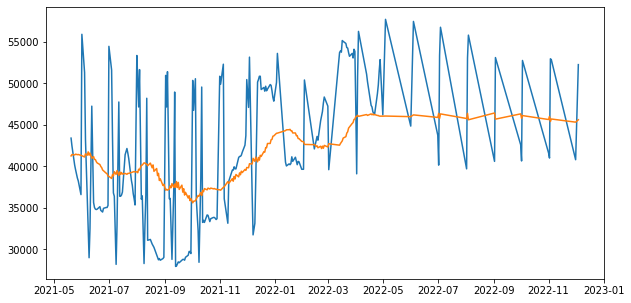

In [18]:
win_size1 = 60
test_cabaimerahbesar_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabaimerahbesar_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabaimerahbesar_1 = pd.DataFrame()
data_new_cabaimerahbesar_1['actual'] = x_test
data_new_cabaimerahbesar_1['prediction'] = data_result_1
data_new_cabaimerahbesar_1.to_csv('cabaimerahbesar_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar_1.actual)
plt.plot(y_test, data_new_cabaimerahbesar_1.prediction)
data_new_cabaimerahbesar

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0368 - mae: 0.1533 - mape: 703640.9375 - val_loss: 0.0639 - val_mae: 0.2160 - val_mape: 67.8047
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0367 - mae: 0.1543 - mape: 708714.9375 - val_loss: 0.0631 - val_mae: 0.2145 - val_mape: 68.0664
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0367 - mae: 0.1544 - mape: 715775.5625 - val_loss: 0.0628 - val_mae: 0.2139 - val_mape: 68.2076
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0367 - mae: 0.1551 - mape: 727431.1875 - val_loss: 0.0628 - val_mae: 0.2139 - val_mape: 68.2445
Epoch 5/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0367 - mae: 0.1543 - mape: 712865.4375 - val_loss: 0.0626 - val_mae: 0.2136 - val_mape: 68.3178
Epoch 6/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0367 - mae: 0.1549 - mape: 723707.4375 - val_loss: 0.0625 - val_mae: 0

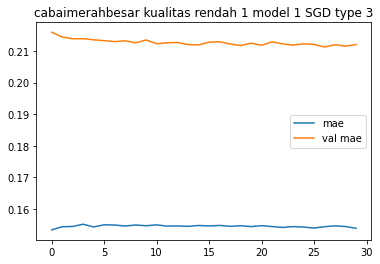

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
5980.233 14.846796 6998.6312947604265


,actual,prediction
0,43400,41732.074219
1,42450,41899.773438
2,40150,41856.992188
3,39600,41955.808594
4,38600,41892.875000
...,...,...
229,41000,46830.046875
230,52950,46184.175781
231,52850,46486.828125
232,40800,46090.121094


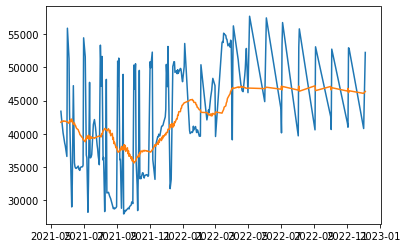

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabaimerahbesar_2 = pd.DataFrame()
# data_new_cabaimerahbesar1['date'] = date_test
data_new_cabaimerahbesar_2['actual'] = x_test
data_new_cabaimerahbesar_2['prediction'] = data_result_2
data_new_cabaimerahbesar_2.to_csv('cabaimerahbesar_model1_sgd_type3')

plt.plot(y_test, data_new_cabaimerahbesar_2.actual)
plt.plot(y_test, data_new_cabaimerahbesar_2.prediction)
data_new_cabaimerahbesar_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 5s 41ms/step - loss: 0.1033 - mae: 0.2598 - mape: 75.6552 - val_loss: 0.2099 - val_mae: 0.4003 - val_mape: 66.3344
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0577 - mae: 0.1763 - mape: 49.5429 - val_loss: 0.0920 - val_mae: 0.2711 - val_mape: 64.4297
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0338 - mae: 0.1514 - mape: 65.9571 - val_loss: 0.0640 - val_mae: 0.2160 - val_mape: 67.5424
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0329 - mae: 0.1553 - mape: 72.3300 - val_loss: 0.0684 - val_mae: 0.2255 - val_mape: 66.2863
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0328 - mae: 0.1541 - mape: 71.5433 - val_loss: 0.0666 - val_mae: 0.2216 - val_mape: 66.7828
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0327 - mae: 0.1536 - mape: 71.0752 - val_loss: 0.0666 - val_mae: 0.2217 - val_mape: 66.812

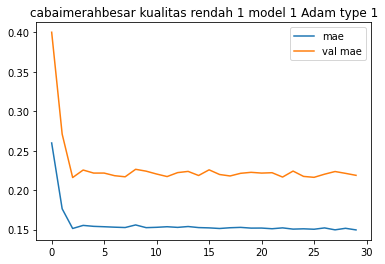

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
6002.6895 14.736551 7069.560099468707


,actual,prediction
0,43400,41371.996094
1,42450,41415.082031
2,40150,41487.648438
3,39600,41507.167969
4,38600,41537.546875
...,...,...
229,41000,45613.750000
230,52950,45133.636719
231,52850,45301.093750
232,40800,44998.964844


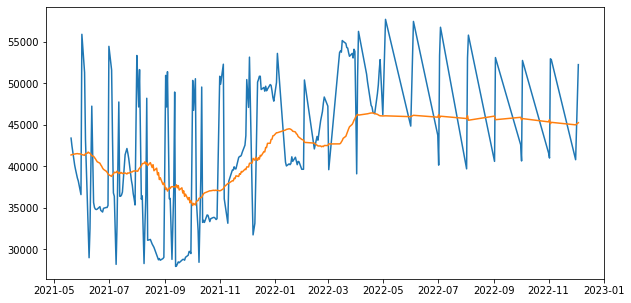

In [25]:
prediction_a = forecast_predict(model_a, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabaimerahbesar_a = pd.DataFrame()
# data_new_cabaimerahbesar1['date'] = date_test
data_new_cabaimerahbesar_a['actual'] = x_test
data_new_cabaimerahbesar_a['prediction'] = data_result_a
data_new_cabaimerahbesar_a.to_csv('cabaimerahbesar_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabaimerahbesar_a.actual)
plt.plot(y_test, data_new_cabaimerahbesar_a.prediction)
data_new_cabaimerahbesar_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0293 - mae: 0.1323 - mape: 360917.8125 - val_loss: 0.0666 - val_mae: 0.2212 - val_mape: 67.5985
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0291 - mae: 0.1321 - mape: 313741.1875 - val_loss: 0.0684 - val_mae: 0.2249 - val_mape: 67.1622
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0289 - mae: 0.1320 - mape: 332342.6562 - val_loss: 0.0631 - val_mae: 0.2146 - val_mape: 69.9722
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0285 - mae: 0.1321 - mape: 396017.7812 - val_loss: 0.0632 - val_mae: 0.2149 - val_mape: 70.1017
Epoch 5/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0284 - mae: 0.1312 - mape: 423948.0625 - val_loss: 0.0789 - val_mae: 0.2465 - val_mape: 65.7618
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0283 - mae: 0.1300 - mape: 405183.7812 - val_loss: 0.0673 - val_

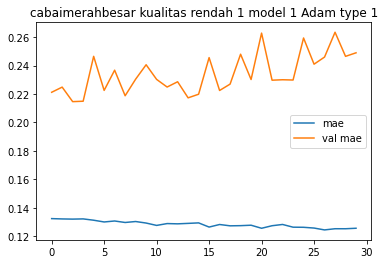

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6166.116 15.291918 7242.671882668716


,actual,prediction
0,43400,44208.660156
1,42450,43948.382812
2,40150,44174.253906
3,39600,43818.566406
4,38600,43979.113281
...,...,...
229,41000,44676.925781
230,52950,43389.367188
231,52850,43966.269531
232,40800,43296.835938


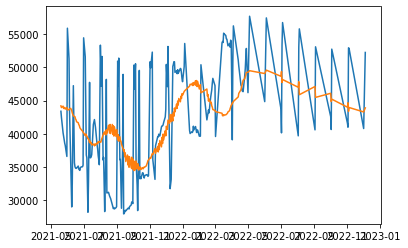

In [28]:
prediction_a1 = forecast_predict(model_a, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabaimerahbesar_a1 = pd.DataFrame()
data_new_cabaimerahbesar_a1['actual'] = x_test
data_new_cabaimerahbesar_a1['prediction'] = data_result_a1
data_new_cabaimerahbesar_a1.to_csv('cabaimerahbesar_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerahbesar_a1.actual)
plt.plot(y_test, data_new_cabaimerahbesar_a1.prediction)
data_new_cabaimerahbesar_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0343 - mae: 0.1451 - mape: 597065.7500 - val_loss: 0.0730 - val_mae: 0.2335 - val_mape: 64.6858
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0338 - mae: 0.1442 - mape: 642493.2500 - val_loss: 0.0710 - val_mae: 0.2291 - val_mape: 64.9823
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0338 - mae: 0.1461 - mape: 671096.8750 - val_loss: 0.0730 - val_mae: 0.2335 - val_mape: 64.7238
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0338 - mae: 0.1449 - mape: 635967.7500 - val_loss: 0.0733 - val_mae: 0.2344 - val_mape: 64.6973
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0339 - mae: 0.1459 - mape: 653011.0625 - val_loss: 0.0776 - val_mae: 0.2428 - val_mape: 64.1712
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0336 - mae: 0.1441 - mape: 632599.8750 - val_loss: 0.0727 - val_mae: 0

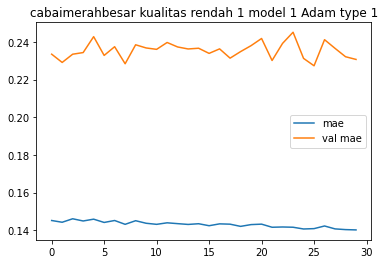

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
6645.352 16.783009 7890.13434613125


,actual,prediction
0,43400,48009.433594
1,42450,47762.652344
2,40150,48216.726562
3,39600,47715.804688
4,38600,48031.734375
...,...,...
229,41000,44354.871094
230,52950,43162.394531
231,52850,43600.187500
232,40800,43151.968750


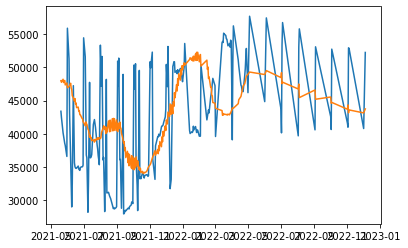

In [31]:
prediction_a2 = forecast_predict(model_a, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabaimerahbesar_a2 = pd.DataFrame()
# data_new_cabaimerahbesar1['date'] = date_test
data_new_cabaimerahbesar_a2['actual'] = x_test
data_new_cabaimerahbesar_a2['prediction'] = data_result_a2
data_new_cabaimerahbesar_a2.to_csv('cabaimerahbesar_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabaimerahbesar_a2.actual)
plt.plot(y_test, data_new_cabaimerahbesar_a2.prediction)
data_new_cabaimerahbesar_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 44ms/step - loss: 0.1025 - mae: 0.2576 - mape: 76.1965 - val_loss: 0.1403 - val_mae: 0.3291 - val_mape: 62.1409
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0376 - mae: 0.1637 - mape: 73.4146 - val_loss: 0.0769 - val_mae: 0.2466 - val_mape: 64.8211
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0350 - mae: 0.1577 - mape: 69.0579 - val_loss: 0.0659 - val_mae: 0.2215 - val_mape: 65.7706
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0382 - mae: 0.1636 - mape: 74.4219 - val_loss: 0.0705 - val_mae: 0.2329 - val_mape: 65.3081
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0359 - mae: 0.1649 - mape: 80.8619 - val_loss: 0.0864 - val_mae: 0.2629 - val_mape: 64.2864
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0348 - mae: 0.1588 - mape: 71.6396 - val_loss: 0.0742 - val_mae: 0.2406 - val_mape: 65.105

17/17 [==============================] - 0s 7ms/step - loss: 0.0698 - mae: 0.2152 - mape: 28.6609


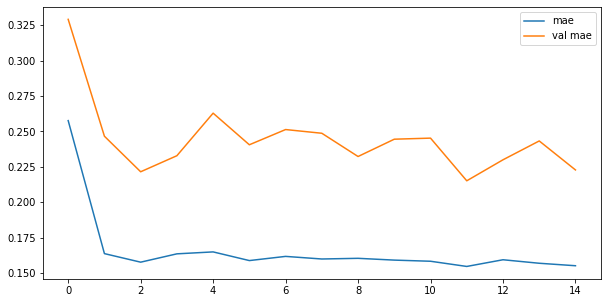

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabaimerahbesar1 = pd.DataFrame()
data_new_cabaimerahbesar1['actual'] = x_test
data_new_cabaimerahbesar1['prediction'] = data_result1
data_new_cabaimerahbesar1.to_csv('cabaimerahbesar_model2_adam_type1.csv')

data_new_cabaimerahbesar1

131/131 [==============================] - 2s 8ms/step
6324.256 15.642052 7352.226873539744


,actual,prediction
0,43400,41192.996094
1,42450,41199.949219
2,40150,41270.480469
3,39600,41295.082031
4,38600,41334.246094
...,...,...
229,41000,45027.378906
230,52950,45296.906250
231,52850,44878.429688
232,40800,45195.558594


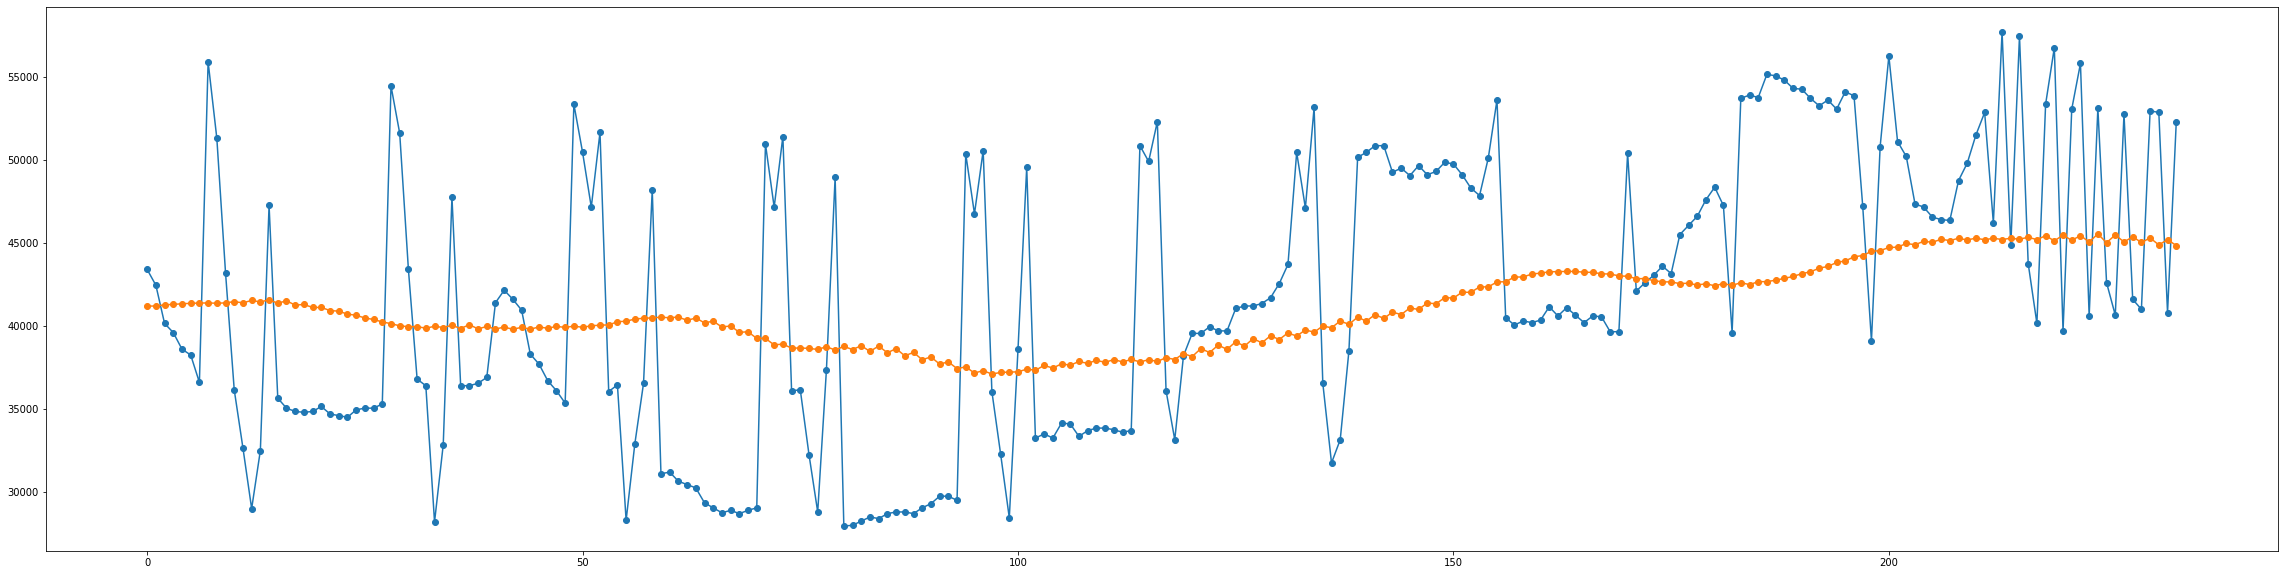

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabaimerahbesar1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabaimerahbesar1['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0303 - mae: 0.1361 - mape: 326138.6875 - val_loss: 0.0721 - val_mae: 0.2342 - val_mape: 65.8900
Epoch 2/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0297 - mae: 0.1348 - mape: 516939.2812 - val_loss: 0.0772 - val_mae: 0.2449 - val_mape: 65.5575
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0290 - mae: 0.1330 - mape: 355909.1562 - val_loss: 0.0686 - val_mae: 0.2254 - val_mape: 66.8380
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0285 - mae: 0.1312 - mape: 433436.5312 - val_loss: 0.0827 - val_mae: 0.2562 - val_mape: 65.4768
Epoch 5/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0286 - mae: 0.1331 - mape: 353762.6250 - val_loss: 0.0604 - val_mae: 0.2066 - val_mape: 72.9202
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0286 - mae: 0.1313 - mape: 381826.3125 - val_loss: 0.0637 - val

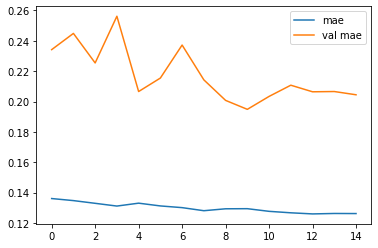

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6090.5845 14.698303 7352.226873539744


,actual,prediction
0,43400,43102.914062
1,42450,42921.105469
2,40150,42875.195312
3,39600,42805.335938
4,38600,42554.027344
...,...,...
229,41000,41438.386719
230,52950,42137.445312
231,52850,40872.960938
232,40800,42004.324219


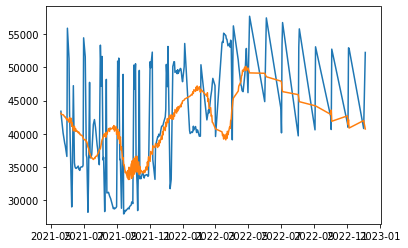

In [39]:
prediction1_1 = forecast_predict(model1, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabaimerahbesar1_1 = pd.DataFrame()
data_new_cabaimerahbesar1_1['actual'] = x_test
data_new_cabaimerahbesar1_1['prediction'] = data_result1_1
data_new_cabaimerahbesar1_1.to_csv('cabaimerahbesar_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerahbesar1_1.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_1.prediction)
data_new_cabaimerahbesar1_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0337 - mae: 0.1472 - mape: 568179.8125 - val_loss: 0.0600 - val_mae: 0.2068 - val_mape: 66.5927
Epoch 2/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0336 - mae: 0.1452 - mape: 584064.4375 - val_loss: 0.0595 - val_mae: 0.2058 - val_mape: 67.7483
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0332 - mae: 0.1430 - mape: 592573.6875 - val_loss: 0.0582 - val_mae: 0.2038 - val_mape: 70.3301
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0334 - mae: 0.1424 - mape: 548107.0625 - val_loss: 0.0583 - val_mae: 0.2038 - val_mape: 70.7956
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0330 - mae: 0.1417 - mape: 604749.3125 - val_loss: 0.0587 - val_mae: 0.2047 - val_mape: 69.9287
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0331 - mae: 0.1435 - mape: 586329.6875 - val_loss: 0.0600 - val_mae: 0

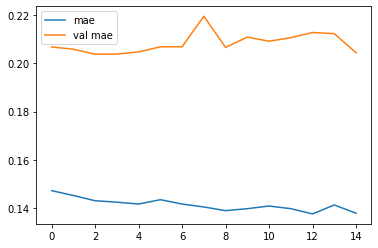

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
6607.918 16.668737 7782.959334340634


,actual,prediction
0,43400,46305.085938
1,42450,46202.972656
2,40150,46223.714844
3,39600,46239.167969
4,38600,45903.542969
...,...,...
229,41000,44344.246094
230,52950,44845.621094
231,52850,43306.746094
232,40800,44299.980469


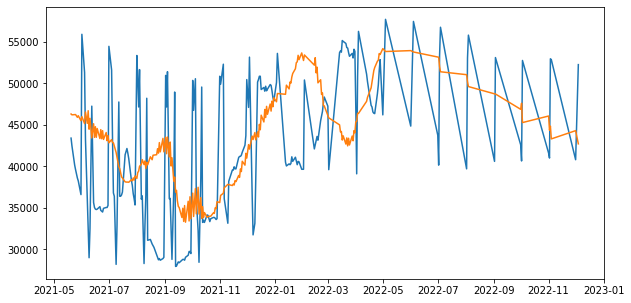

In [42]:
prediction1_2 = forecast_predict(model1, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabaimerahbesar1_2 = pd.DataFrame()
data_new_cabaimerahbesar1_2['actual'] = x_test
data_new_cabaimerahbesar1_2['prediction'] = data_result1_2
data_new_cabaimerahbesar1_2.to_csv('cabaimerahbesar_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar1_2.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_2.prediction)

data_new_cabaimerahbesar1_2

### SGD

In [43]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [44]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [45]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 47ms/step - loss: 0.1325 - mae: 0.3071 - mape: 96.5726 - val_loss: 0.3193 - val_mae: 0.5152 - val_mape: 93.5590
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1002 - mae: 0.2509 - mape: 70.6157 - val_loss: 0.2658 - val_mae: 0.4602 - val_mape: 78.4061
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0794 - mae: 0.2092 - mape: 52.7525 - val_loss: 0.2276 - val_mae: 0.4190 - val_mape: 68.7947
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0652 - mae: 0.1829 - mape: 45.6007 - val_loss: 0.1993 - val_mae: 0.3901 - val_mape: 65.0279
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0553 - mae: 0.1703 - mape: 46.5430 - val_loss: 0.1778 - val_mae: 0.3680 - val_mape: 63.0809
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0488 - mae: 0.1636 - mape: 49.8257 - val_loss: 0.1604 - val_mae: 0.3499 - val_mape: 62.050

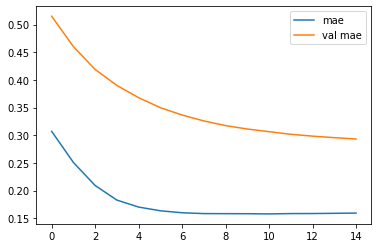

In [46]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
7117.34 16.918787 8529.890972339565


,actual,prediction
0,43400,39267.792969
1,42450,39276.074219
2,40150,39282.203125
3,39600,39285.074219
4,38600,39295.175781
...,...,...
229,41000,39526.656250
230,52950,39575.414062
231,52850,39535.382812
232,40800,39574.757812


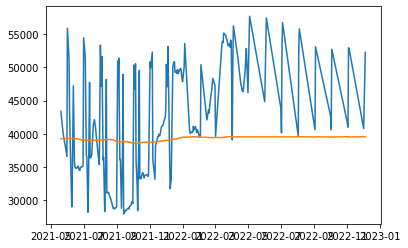

In [47]:
prediction1_a = forecast_predict(model1_a, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabaimerahbesar1_a = pd.DataFrame()
data_new_cabaimerahbesar1_a['actual'] = x_test
data_new_cabaimerahbesar1_a['prediction'] = data_result1_a
data_new_cabaimerahbesar1_a.to_csv('cabaimerahbesar_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabaimerahbesar1_a.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_a.prediction)

data_new_cabaimerahbesar1_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0335 - mae: 0.1458 - mape: 386998.8125 - val_loss: 0.0953 - val_mae: 0.2765 - val_mape: 63.4360
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0330 - mae: 0.1446 - mape: 368534.1875 - val_loss: 0.0942 - val_mae: 0.2750 - val_mape: 63.5400
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0331 - mae: 0.1447 - mape: 378158.0938 - val_loss: 0.0911 - val_mae: 0.2704 - val_mape: 63.7351
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0329 - mae: 0.1447 - mape: 398062.9688 - val_loss: 0.0929 - val_mae: 0.2731 - val_mape: 63.6883
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0327 - mae: 0.1441 - mape: 417886.1250 - val_loss: 0.0909 - val_mae: 0.2701 - val_mape: 63.8215
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0326 - mae: 0.1433 - mape: 377553.1562 - val_loss: 0.0884 - val_

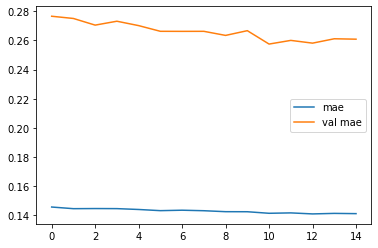

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6607.0723 15.897597 7887.394500086832


,actual,prediction
0,43400,39904.687500
1,42450,39935.062500
2,40150,39950.199219
3,39600,39972.195312
4,38600,39991.277344
...,...,...
229,41000,42151.265625
230,52950,42058.511719
231,52850,42070.820312
232,40800,41979.433594


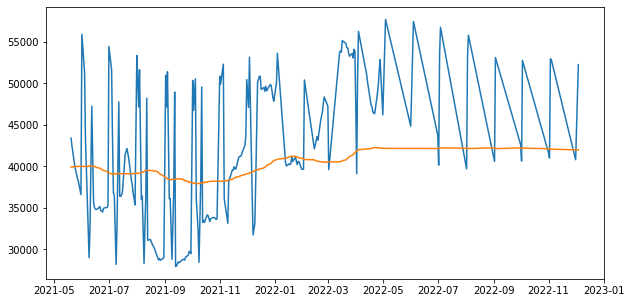

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabaimerahbesar1_a1 = pd.DataFrame()
data_new_cabaimerahbesar1_a1['actual'] = x_test
data_new_cabaimerahbesar1_a1['prediction'] = data_result1_a1
data_new_cabaimerahbesar1_a1.to_csv('cabaimerahbesar_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar1_a1.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_a1.prediction)
data_new_cabaimerahbesar1_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0408 - mae: 0.1617 - mape: 687387.5625 - val_loss: 0.0795 - val_mae: 0.2510 - val_mape: 64.7819
Epoch 2/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0403 - mae: 0.1632 - mape: 741294.9375 - val_loss: 0.0770 - val_mae: 0.2463 - val_mape: 64.9127
Epoch 3/15
84/84 [==============================] - 2s 22ms/step - loss: 0.0401 - mae: 0.1632 - mape: 739876.3125 - val_loss: 0.0756 - val_mae: 0.2436 - val_mape: 64.9800
Epoch 4/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0400 - mae: 0.1635 - mape: 748607.9375 - val_loss: 0.0749 - val_mae: 0.2422 - val_mape: 65.0324
Epoch 5/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0400 - mae: 0.1636 - mape: 755471.3750 - val_loss: 0.0742 - val_mae: 0.2406 - val_mape: 65.0805
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0400 - mae: 0.1643 - mape: 760694.9375 - val_loss: 0.0732 - val_mae: 0

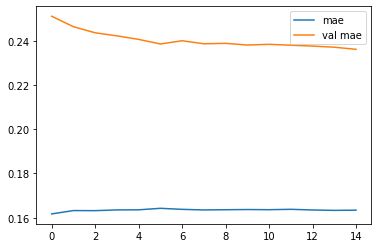

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
6563.8755 16.470724 7589.914624025754


,actual,prediction
0,43400,41535.316406
1,42450,41568.539062
2,40150,41584.660156
3,39600,41609.597656
4,38600,41629.453125
...,...,...
229,41000,44148.300781
230,52950,44042.152344
231,52850,44063.394531
232,40800,43959.585938


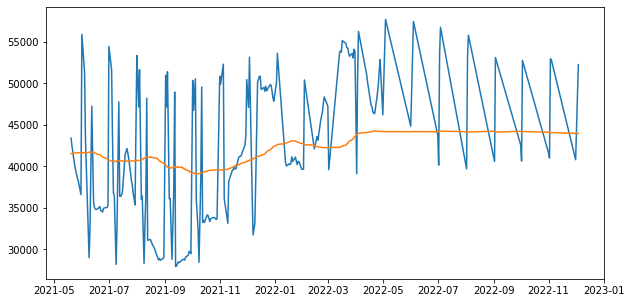

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabaimerahbesar1_a2 = pd.DataFrame()
data_new_cabaimerahbesar1_a2['actual'] = x_test
data_new_cabaimerahbesar1_a2['prediction'] = data_result1_a2
data_new_cabaimerahbesar1_a2.to_csv('cabaimerahbesar_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar1_a2.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_a2.prediction)

data_new_cabaimerahbesar1_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 37ms/step - loss: 0.1237 - mae: 0.2953 - mape: 92.0261 - val_loss: 0.3036 - val_mae: 0.4994 - val_mape: 89.0419
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0996 - mae: 0.2500 - mape: 70.1618 - val_loss: 0.2611 - val_mae: 0.4548 - val_mape: 76.7801
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0814 - mae: 0.2136 - mape: 54.2592 - val_loss: 0.2304 - val_mae: 0.4217 - val_mape: 69.2686
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0688 - mae: 0.1894 - mape: 46.7856 - val_loss: 0.2057 - val_mae: 0.3966 - val_mape: 65.7854
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0596 - mae: 0.1759 - mape: 46.3150 - val_loss: 0.1864 - val_mae: 0.3768 - val_mape: 63.7986
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0527 - mae: 0.1672 - mape: 47.4305 - val_loss: 0.1713 - val_mae: 0.3611 - val_mape: 62.676

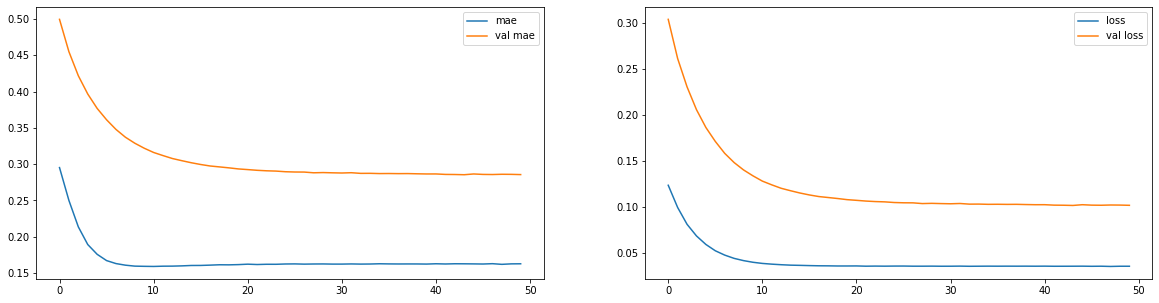

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
7072.965 17.088806 8425.579149233601


,actual,prediction
0,43400,39832.339844
1,42450,39866.683594
2,40150,39830.457031
3,39600,39841.230469
4,38600,39838.710938
...,...,...
229,41000,40174.105469
230,52950,40155.355469
231,52850,40174.941406
232,40800,40173.562500


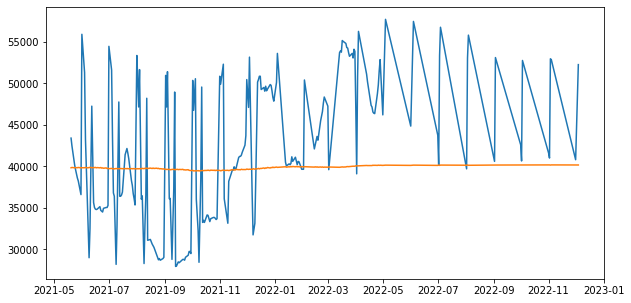

In [58]:
prediction2 = forecast_predict(model2, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabaimerahbesar2 = pd.DataFrame()
data_new_cabaimerahbesar2['actual'] = x_test
data_new_cabaimerahbesar2['prediction'] = data_result2
data_new_cabaimerahbesar2.to_csv('cabaimerahbesar_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar2.actual)
plt.plot(y_test, data_new_cabaimerahbesar2.prediction)
data_new_cabaimerahbesar2

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0341 - mae: 0.1470 - mape: 389905.2188 - val_loss: 0.0982 - val_mae: 0.2805 - val_mape: 63.1315
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0341 - mae: 0.1469 - mape: 384063.6562 - val_loss: 0.0964 - val_mae: 0.2781 - val_mape: 63.2210
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0339 - mae: 0.1472 - mape: 395583.2812 - val_loss: 0.0985 - val_mae: 0.2809 - val_mape: 63.1309
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0340 - mae: 0.1467 - mape: 468529.6875 - val_loss: 0.0980 - val_mae: 0.2803 - val_mape: 63.1553
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0337 - mae: 0.1469 - mape: 381587.4375 - val_loss: 0.0975 - val_mae: 0.2796 - val_mape: 63.1888
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0338 - mae: 0.1467 - mape: 431822.7500 - val_loss: 0.0938 - val_

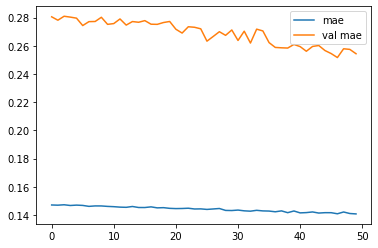

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabaimerahbesar2_1 = pd.DataFrame()
data_new_cabaimerahbesar2_1['actual'] = x_test
data_new_cabaimerahbesar2_1['prediction'] = data_result2_1
data_new_cabaimerahbesar2_1.to_csv('cabaimerahbesar_model3_sgd_type2.csv')

data_new_cabaimerahbesar2

199/199 [==============================] - 1s 4ms/step
6684.5796 16.121176 7958.530015021618


,actual,prediction
0,43400,39832.339844
1,42450,39866.683594
2,40150,39830.457031
3,39600,39841.230469
4,38600,39838.710938
...,...,...
229,41000,40174.105469
230,52950,40155.355469
231,52850,40174.941406
232,40800,40173.562500


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0409 - mae: 0.1628 - mape: 648307.0625 - val_loss: 0.0774 - val_mae: 0.2469 - val_mape: 64.5759
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0406 - mae: 0.1638 - mape: 702184.2500 - val_loss: 0.0756 - val_mae: 0.2433 - val_mape: 64.6871
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0406 - mae: 0.1644 - mape: 735063.8125 - val_loss: 0.0743 - val_mae: 0.2406 - val_mape: 64.7659
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0405 - mae: 0.1644 - mape: 736442.0000 - val_loss: 0.0732 - val_mae: 0.2383 - val_mape: 64.8367
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0402 - mae: 0.1649 - mape: 760753.3125 - val_loss: 0.0734 - val_mae: 0.2388 - val_mape: 64.8279
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0401 - mae: 0.1638 - mape: 757603.6875 - val_loss: 0.0736 - val_mae: 0

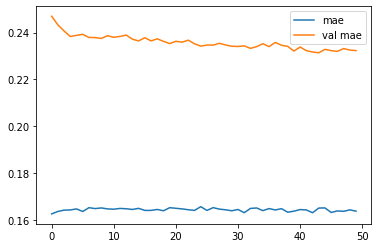

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabaimerahbesar2_2 = pd.DataFrame()
data_new_cabaimerahbesar2_2['actual'] = x_test
data_new_cabaimerahbesar2_2['prediction'] = data_result2_2
data_new_cabaimerahbesar2_2.to_csv('cabaimerahbesar_model3_sgd-type3.csv')

data_new_cabaimerahbesar2_2

181/181 [==============================] - 1s 4ms/step
6567.041 16.332548 7627.273431574353


,actual,prediction
0,43400,41255.503906
1,42450,41316.230469
2,40150,41414.246094
3,39600,41415.890625
4,38600,41267.679688
...,...,...
229,41000,44316.960938
230,52950,44140.527344
231,52850,44180.093750
232,40800,44139.441406


### Adam

In [65]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 34ms/step - loss: 0.1056 - mae: 0.2619 - mape: 75.9887 - val_loss: 0.2212 - val_mae: 0.4117 - val_mape: 67.4424
Epoch 2/50
44/44 [==============================] - 1s 18ms/step - loss: 0.0474 - mae: 0.1631 - mape: 60.1631 - val_loss: 0.1088 - val_mae: 0.2944 - val_mape: 62.7408
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0359 - mae: 0.1614 - mape: 73.3693 - val_loss: 0.1087 - val_mae: 0.2942 - val_mape: 62.7521
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0364 - mae: 0.1671 - mape: 79.0970 - val_loss: 0.1111 - val_mae: 0.2971 - val_mape: 62.6583
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0360 - mae: 0.1640 - mape: 76.5767 - val_loss: 0.1149 - val_mae: 0.3015 - val_mape: 62.5139
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0358 - mae: 0.1631 - mape: 75.4035 - val_loss: 0.1066 - val_mae: 0.2916 - val_mape: 62.853

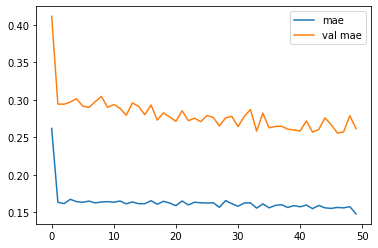

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabaimerahbesar2_a = pd.DataFrame()
data_new_cabaimerahbesar2_a['actual'] = x_test
data_new_cabaimerahbesar2_a['prediction'] = data_result2_a
data_new_cabaimerahbesar2_a.to_csv('cabaimerahbesar_model3_adam-type1.csv')

data_new_cabaimerahbesar2_a

131/131 [==============================] - 1s 6ms/step
6385.9844 15.915157 7403.773092147004


,actual,prediction
0,43400,41959.894531
1,42450,40817.695312
2,40150,42679.488281
3,39600,41295.062500
4,38600,42144.765625
...,...,...
229,41000,44262.644531
230,52950,43576.250000
231,52850,44106.402344
232,40800,43213.062500


#### Type 2

In [69]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0306 - mae: 0.1372 - mape: 401701.4375 - val_loss: 0.0787 - val_mae: 0.2482 - val_mape: 63.6293
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0302 - mae: 0.1386 - mape: 487929.3125 - val_loss: 0.0852 - val_mae: 0.2582 - val_mape: 63.3575
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0290 - mae: 0.1335 - mape: 416091.2188 - val_loss: 0.0707 - val_mae: 0.2283 - val_mape: 64.2254
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0284 - mae: 0.1305 - mape: 440271.0312 - val_loss: 0.0799 - val_mae: 0.2473 - val_mape: 63.1438
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0287 - mae: 0.1310 - mape: 405639.8438 - val_loss: 0.0778 - val_mae: 0.2417 - val_mape: 63.1288
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0289 - mae: 0.1309 - mape: 412721.7500 - val_loss: 0.0681 - val_

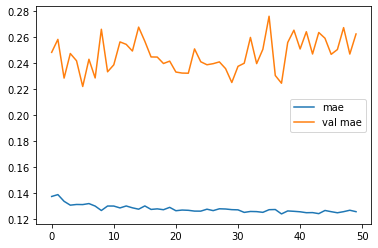

In [70]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6431.36 15.676572 7550.514684443703


,actual,prediction
0,43400,42761.671875
1,42450,42225.738281
2,40150,43455.347656
3,39600,43231.179688
4,38600,43163.644531
...,...,...
229,41000,42653.351562
230,52950,41654.992188
231,52850,42412.585938
232,40800,41413.167969


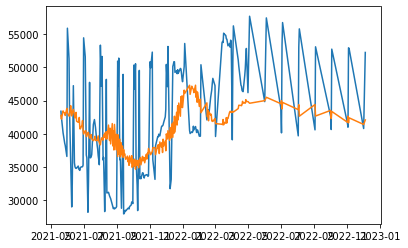

In [71]:
prediction2_a1 = forecast_predict(model2_a, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabaimerahbesar2_a1 = pd.DataFrame()
data_new_cabaimerahbesar2_a1['actual'] = x_test
data_new_cabaimerahbesar2_a1['prediction'] = data_result2_a1
data_new_cabaimerahbesar2_a1.to_csv('cabaimerahbesar_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabaimerahbesar2_a1.actual)
plt.plot(y_test, data_new_cabaimerahbesar2_a1.prediction)
data_new_cabaimerahbesar2_a1

#### Type 3

In [72]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0350 - mae: 0.1461 - mape: 672949.5625 - val_loss: 0.0756 - val_mae: 0.2405 - val_mape: 64.6143
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0342 - mae: 0.1475 - mape: 695650.9375 - val_loss: 0.0727 - val_mae: 0.2337 - val_mape: 64.8455
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0340 - mae: 0.1451 - mape: 654226.4375 - val_loss: 0.0704 - val_mae: 0.2288 - val_mape: 65.1674
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0342 - mae: 0.1458 - mape: 672663.1250 - val_loss: 0.0726 - val_mae: 0.2333 - val_mape: 64.8393
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0339 - mae: 0.1453 - mape: 727066.1875 - val_loss: 0.0724 - val_mae: 0.2326 - val_mape: 64.8646
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0339 - mae: 0.1448 - mape: 661794.7500 - val_loss: 0.0740 - val_mae: 0

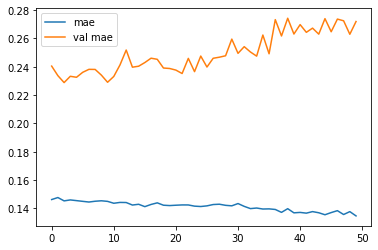

In [73]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
7026.3516 17.514547 8450.823865162496


,actual,prediction
0,43400,46818.996094
1,42450,47054.105469
2,40150,47877.023438
3,39600,46237.535156
4,38600,48685.796875
...,...,...
229,41000,43036.253906
230,52950,41930.585938
231,52850,42096.476562
232,40800,41865.687500


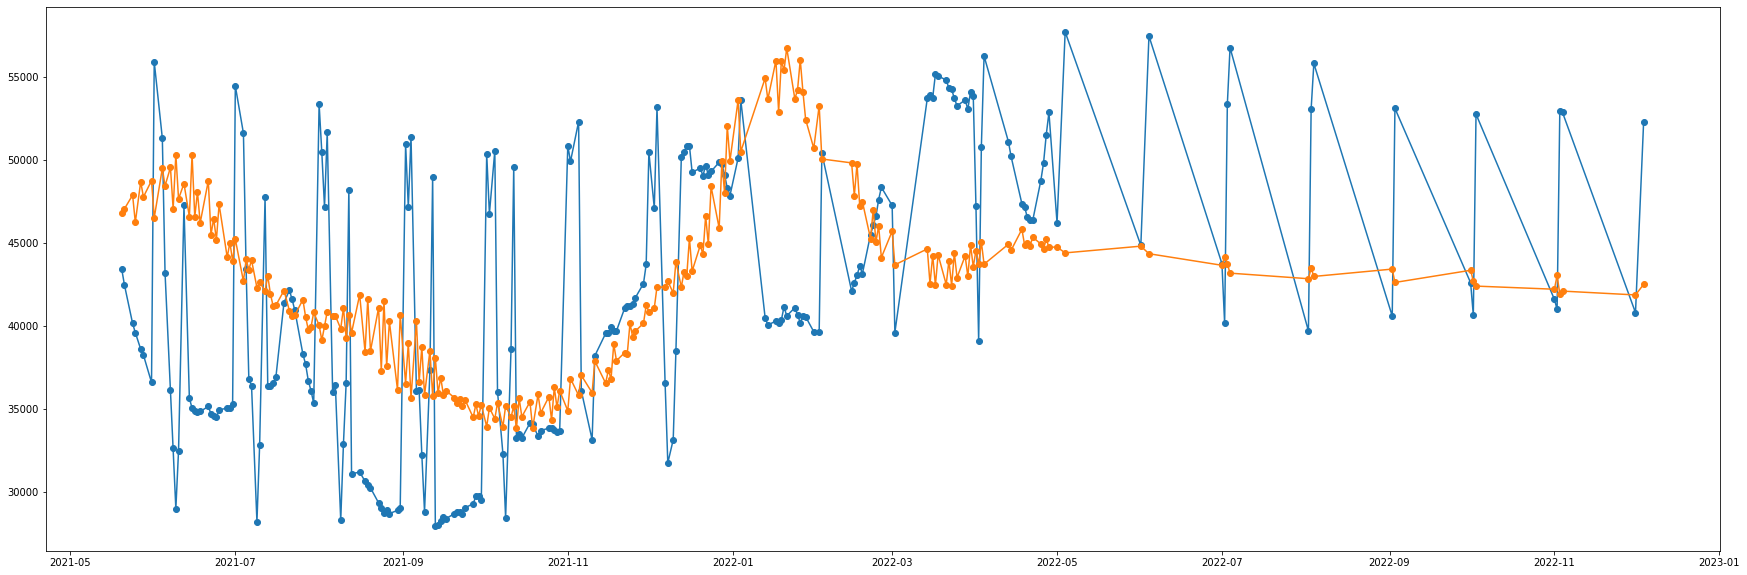

In [74]:
prediction2_a2 = forecast_predict(model2_a, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabaimerahbesar2_a2 = pd.DataFrame()
data_new_cabaimerahbesar2_a2['actual'] = x_test
data_new_cabaimerahbesar2_a2['prediction'] = data_result2_a2
data_new_cabaimerahbesar2_a2.to_csv('cabaimerahbesar_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabaimerahbesar2_a2.actual, '-o')
plt.plot(y_test,data_new_cabaimerahbesar2_a2.prediction, '-o')
data_new_cabaimerahbesar2_a2